# Baseline: Бинарная классификация без учета тритмента

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5
from feature_extraction import UpliftFeatureExtractor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [2]:
dataset = fetch_x5()
data = dataset.data

In [3]:
# подсчет фич
extractor = UpliftFeatureExtractor(drop_redundant=True)
df = extractor.calculate_features(
    clients_df=data.clients,
    train_df=data.train,
    treatment_df=dataset.treatment,
    target_df=dataset.target,
    purchases_df=data.purchases
)

features = extractor.feature_names

print(f"Создано признаков: {len(features)}")
print(f"Размер датафрейма: {df.shape}")
print(f"Признаки: {features}")

Создано признаков: 32
Размер датафрейма: (200039, 34)
Признаки: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'gender', 'is_activated']


In [4]:
df.isna().sum()

first_issue_month                     0
first_issue_weekday                   0
first_issue_year_quarter_idx          0
total_transactions                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
total_express_points_received         0
total_express_points_spent            0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
unique_products_count                 0
avg_product_quantity                  0
transaction_period_days               0
first_transaction_quarter             0
first_transaction_year_quarter_idx    0
unique_stores_visited                 0
store_loyalty_ratio                   0
avg_purchase_per_day                  0
transactions_per_month                0
points_spend_ratio                    0
points_balance_ratio                  0
unique_store_intensity                0
log_total_purchase_sum                0
seasonal_quarter_code                 0


# Baseline модель: Бинарная классификация

In [5]:
# подготовка данных для baseline без тритмента
X_baseline = df[features].copy()
y = df["target"]

# определение категориальных признаков
categorical_features = []
for col in X_baseline.columns:
    if X_baseline[col].dtype.name == "category" or (X_baseline[col].dtype == "object" and X_baseline[col].nunique() < 100):
        categorical_features.append(col)
    
cat_features_indices = [i for i, col in enumerate(X_baseline.columns) if col in categorical_features]

# разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(
    X_baseline, y, 
    test_size=0.2, random_state=67, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Баланс классов в train: {y_train.mean():.3f}")
print(f"Баланс классов в test: {y_test.mean():.3f}")

Размер обучающей выборки: (160031, 32)
Размер тестовой выборки: (40008, 32)
Баланс классов в train: 0.620
Баланс классов в test: 0.620


In [6]:
# обучение baseline модели
baseline_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    eval_metric="AUC",
    verbose=100,
    use_best_model=True,
    random_state=67
)

baseline_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features_indices
)

Learning rate set to 0.111006
0:	test: 0.7513489	best: 0.7513489 (0)	total: 241ms	remaining: 4m
100:	test: 0.7674167	best: 0.7674167 (100)	total: 11.1s	remaining: 1m 38s
200:	test: 0.7677513	best: 0.7677519 (199)	total: 21.6s	remaining: 1m 25s
300:	test: 0.7677022	best: 0.7677576 (222)	total: 32.7s	remaining: 1m 15s
400:	test: 0.7673858	best: 0.7677576 (222)	total: 43.3s	remaining: 1m 4s
500:	test: 0.7669817	best: 0.7677576 (222)	total: 54s	remaining: 53.8s
600:	test: 0.7666057	best: 0.7677576 (222)	total: 1m 4s	remaining: 42.5s
700:	test: 0.7663014	best: 0.7677576 (222)	total: 1m 14s	remaining: 31.7s
800:	test: 0.7658466	best: 0.7677576 (222)	total: 1m 24s	remaining: 21s
900:	test: 0.7654657	best: 0.7677576 (222)	total: 1m 34s	remaining: 10.4s
999:	test: 0.7649958	best: 0.7677576 (222)	total: 1m 43s	remaining: 0us

bestTest = 0.7677576029
bestIteration = 222

Shrink model to first 223 iterations.


In [7]:
# предикты и оценка модели
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
y_pred = baseline_model.predict(X_test)

# метрики
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

AUC Score: 0.7678

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.58     15207
           1       0.74      0.83      0.78     24801

    accuracy                           0.71     40008
   macro avg       0.70      0.68      0.68     40008
weighted avg       0.71      0.71      0.71     40008



In [8]:
# важность признаков в baseline модели
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': baseline_model.get_feature_importance()
}).sort_values('importance', ascending=False)

feature_importance_df.head(15)

,feature,importance
3,total_transactions,23.595402
19,transactions_per_month,15.706971
13,transaction_period_days,14.941651
22,unique_store_intensity,3.787165
2,first_issue_year_quarter_idx,3.499549
29,age,3.276022
31,is_activated,2.918634
5,max_transaction_amount,2.852437
6,min_transaction_amount,2.732224
11,unique_products_count,2.388757


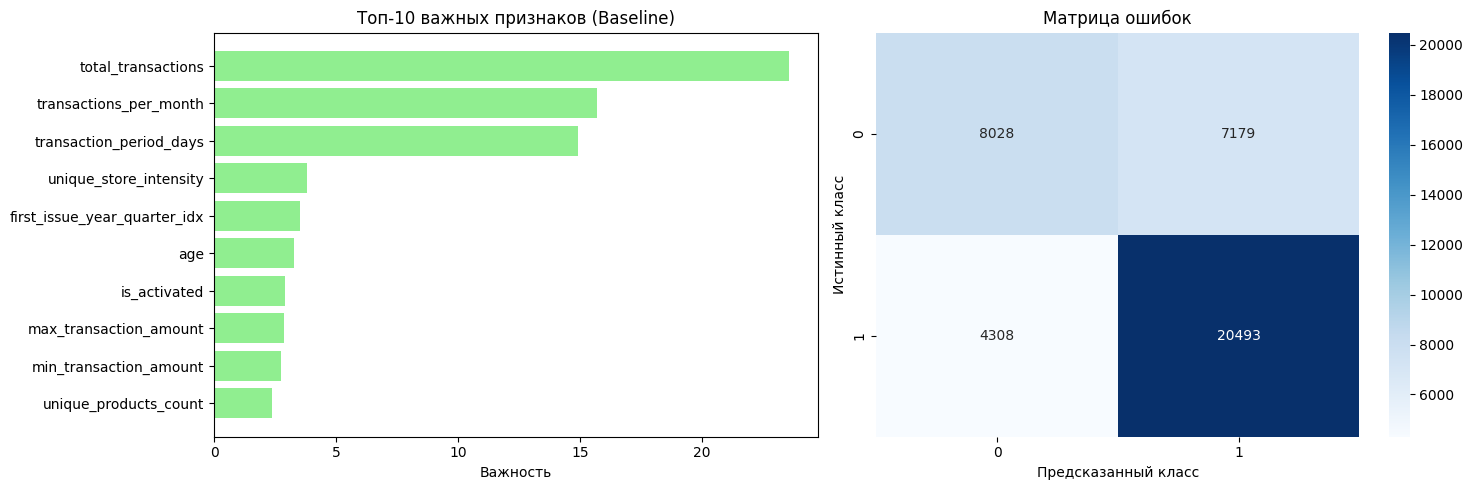

In [9]:
# визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# важность признаков
top_features = feature_importance_df.head(10)
axes[0].barh(top_features['feature'], top_features['importance'], color='lightgreen')
axes[0].set_title('Топ-10 важных признаков (Baseline)')
axes[0].set_xlabel('Важность')
axes[0].invert_yaxis()

# матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Матрица ошибок')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

In [10]:
params = baseline_model.get_all_params()

for k, v in params.items():
    print(f"    '{k}': {repr(v)},")

    'nan_mode': 'Min',
    'eval_metric': 'AUC',
    'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'fold_permutation_block': 0,
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'counter_calc_method': 'SkipTest',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'ctr_leaf_count_limit': 18446744073709551615,
    'bayesian_matrix_reg': 0.10000000149011612,
    'one_hot_max_size': 2,
    'eval_fraction': 0,
    'force_unit_auto_pair_weights': False,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'max_ctr_complexity': 4,
    'model